In [1]:
import os
import os.path as osp
import json
import math
from glob import glob
from pprint import pprint
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import cv2
import albumentations as A
import lanms
import random
from albumentations.pytorch import ToTensorV2
from imageio import imread
from dataset import SceneTextDataset

from model import EAST
from detect import detect

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [2]:
def draw_bbox(image, bbox, color=(0, 0, 255), thickness=1, thickness_sub=None, double_lined=False,
              write_point_numbers=False):
    """이미지에 하나의 bounding box를 그려넣는 함수
    """
    thickness_sub = thickness_sub or thickness * 3
    basis = max(image.shape[:2])
    fontsize = basis / 1500
    x_offset, y_offset = int(fontsize * 12), int(fontsize * 10)
    color_sub = (255 - color[0], 255 - color[1], 255 - color[2])

    points = [(int(np.rint(p[0])), int(np.rint(p[1]))) for p in bbox]

    for idx in range(len(points)):
        if double_lined:
            cv2.line(image, points[idx], points[(idx + 1) % len(points)], color_sub,
                     thickness=thickness_sub)
        cv2.line(image, points[idx], points[(idx + 1) % len(points)], color, thickness=thickness)

    if write_point_numbers:
        for idx in range(len(points)):
            loc = (points[idx][0] - x_offset, points[idx][1] - y_offset)
            if double_lined:
                cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color_sub,
                            thickness_sub, cv2.LINE_AA)
            cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color, thickness,
                        cv2.LINE_AA)

def draw_bboxes(image, bboxes, color=(0, 0, 255), thickness=1, thickness_sub=None,
                double_lined=False, write_point_numbers=False):
    """이미지에 다수의 bounding box들을 그려넣는 함수
    """
    for bbox in bboxes:
        draw_bbox(image, bbox, color=color, thickness=thickness, thickness_sub=thickness_sub,
                  double_lined=double_lined, write_point_numbers=write_point_numbers)

In [3]:
data_dir = '/opt/ml/input/data/merge1719Dataset'  ## datasets path
image_size = 1024
input_size = 512
# dataset = SceneTextDataset(data_dir, split='train', image_size=image_size, crop_size=input_size,color_jitter=True,normalize=False)

with open(osp.join(data_dir, 'ufo/{}.json'.format('val')), 'r') as f:
    anno = json.load(f)
    
image_fnames = sorted(anno['images'].keys())


In [4]:
model = EAST(pretrained=False)
load_from = '//opt/ml/code/trained_models/t4190_pre_geoaug_1719_70epoch_221214_231102.pth'
# model = model.cuda()
try:
    checkpoint = torch.load(load_from)
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
except:
    model.load_state_dict(torch.load(load_from))
    
_ = model.eval()


/tmp/ipykernel_5191/883849177.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_fpath)


Original image:	(4032, 3024, 3)
4032


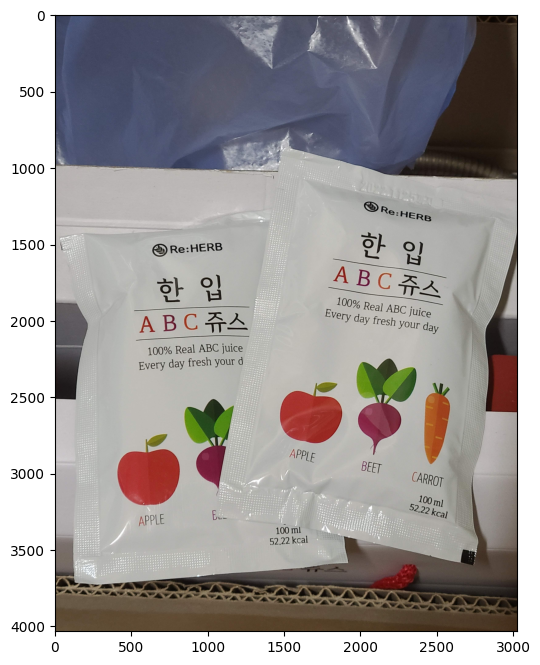

In [58]:
SAMPLE_IDX = 3
image_fname = image_fnames[SAMPLE_IDX]
image_fpath = osp.join(data_dir, 'images', image_fname)
image = imread(image_fpath)
print('Original image:\t{}'.format(image.shape))
orig_size = max(image.shape[:2])
print(orig_size)
plt.figure(figsize=(8,8))
plt.imshow(image)

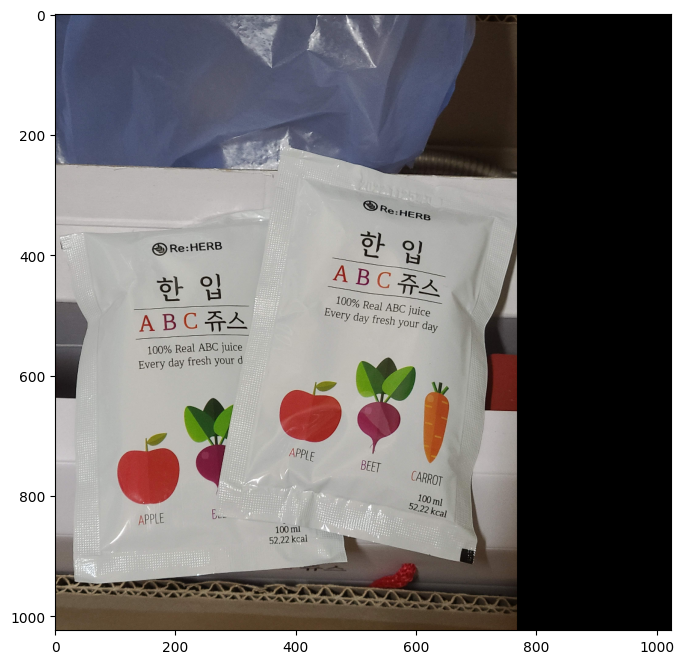

In [59]:
INPUT_SIZE = 1024

prep_fn = A.Compose([
    A.LongestMaxSize(INPUT_SIZE),
    A.PadIfNeeded(min_height=INPUT_SIZE, min_width=INPUT_SIZE, position=A.PadIfNeeded.PositionType.TOP_LEFT, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(), ToTensorV2()
])

# 시각화를 위해 Normalize와 Tensorize를 제외한 버전
prep_fn_vis = A.Compose([
    A.LongestMaxSize(INPUT_SIZE),
    A.PadIfNeeded(min_height=INPUT_SIZE, min_width=INPUT_SIZE, position=A.PadIfNeeded.PositionType.TOP_LEFT, border_mode=cv2.BORDER_CONSTANT)
])

vis = prep_fn_vis(image=image)['image']
plt.figure(figsize=(8,8))
plt.imshow(vis)

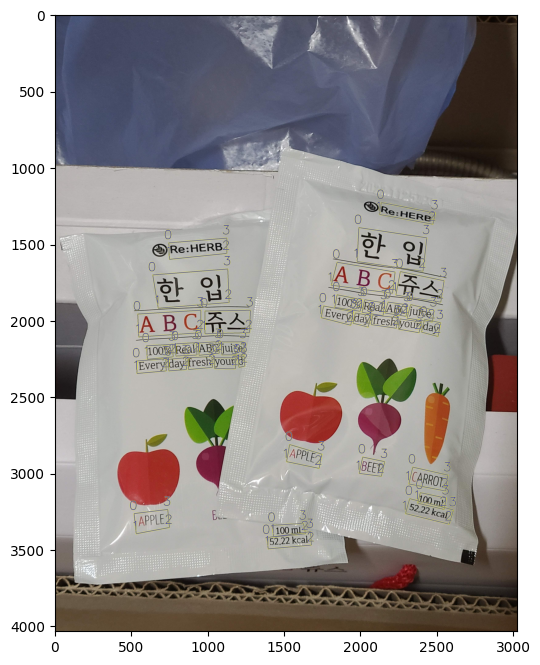

In [60]:
origin_img = plt.imread(os.path.join(data_dir, 'images', image_fname))
anno_keys = anno['images'][image_fname]['words'].keys()
bboxes = []
for k in anno_keys:
    bboxes.append(anno['images'][image_fname]['words'][k]['points'])

plt.figure(figsize=(8, 8))
img = origin_img.copy()
draw_bboxes(img, bboxes, double_lined=True, thickness=2, thickness_sub=5, write_point_numbers=True)

plt.imshow(img)
plt.show()

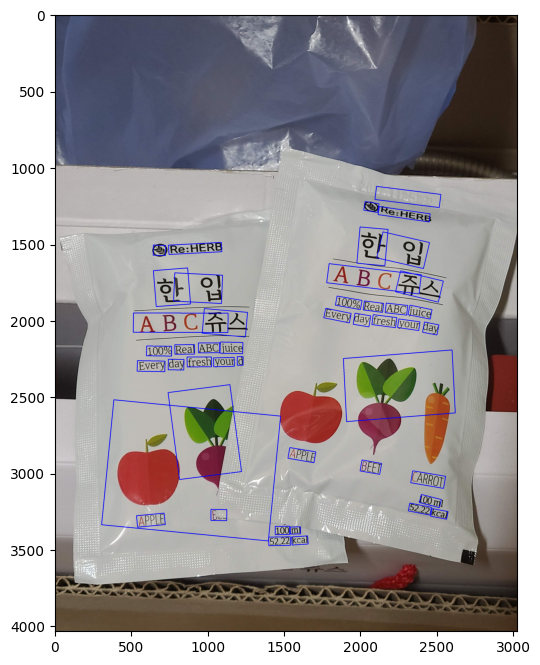

In [65]:
bboxes = detect(model, [image], 2048)[0]

vis = image.copy()
draw_bboxes(vis, bboxes, thickness=3)

plt.figure(figsize=(8,8))
plt.imshow(vis)

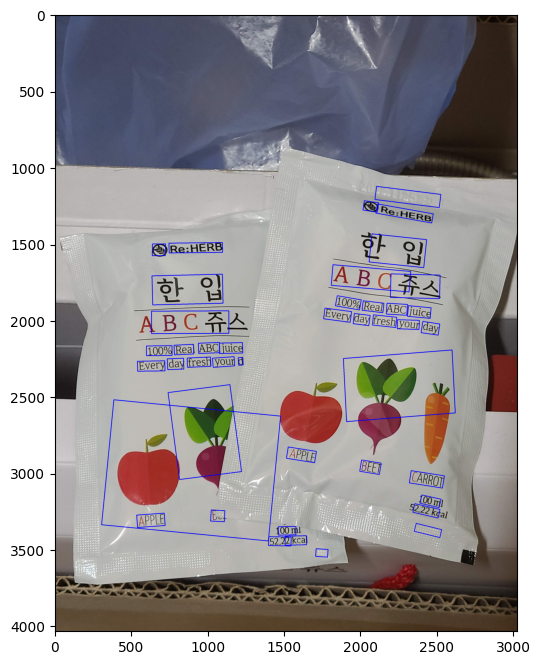

In [64]:
input_size_list = [1024, 2048]
weight_list = [0.9, 0.8]
temp_bboxes = [] ###
for size, weight in zip(input_size_list, weight_list):
    temp = detect(model, [image], size)
    for t in temp:
        bboxes = t.reshape(-1, 8)
        for bbox in bboxes:
            temp_bboxes.append(np.append(bbox, weight))
            # print(bbox)
    # print(temp)
    # print(len(temp))
    # temp_bboxes += temp
    # temp_bboxes.append(temp)
temp_bboxes = np.array(temp_bboxes)
# print(temp_bboxes)
temp_bboxes = lanms.merge_quadrangle_n9(temp_bboxes, 0.2)
# print(temp_bboxes)
if temp_bboxes is None:
    bboxes = np.zeros((0, 4, 2), dtype=np.float32)
else:
    bboxes = temp_bboxes[:, :8].reshape(-1, 4, 2)
    # bboxes *= orig_size / 1024
vis = image.copy()
draw_bboxes(vis, bboxes, thickness=3)

plt.figure(figsize=(8,8))
plt.imshow(vis)

In [63]:
boxes = np.array([
     [137.0, 113.6, 162.3, 113.3, 162.4, 122.2, 137.2, 122.6, 0.7],
     [137.2, 113.8, 163.2, 114.6, 163.0, 122.6, 137.0, 121.9, 0.7],
     [136.8, 113.4, 163.2, 114.5, 162.9, 122.7, 136.5, 121.6, 0.7],
     [136.6, 112.9, 163.3, 114.5, 162.8, 122.9, 136.1, 121.3, 0.7],
     [136.4, 112.6, 163.4, 114.5, 162.8, 123.0, 135.8, 121.2, 0.7],
     [131.4, 89.2,  137.8, 89.0,  138.2, 98.5,  131.8,  98.7, 0.7],
     [131.6, 89.2,  137.8, 89.1,  138.1, 98.6,  131.8,  98.8, 0.7],
     [131.5, 89.2,  137.9, 89.1,  138.0, 98.6,  131.6,  98.7, 0.7],
     [131.5, 89.2,  138.0, 89.1,  138.1, 98.5,  131.6,  98.5, 0.7],
     [131.5, 89.3,  137.8, 89.0,  138.2, 98.4,  132.0,  98.7, 0.7],
         [137.0, 113.6, 162.3, 113.3, 162.4, 122.2, 137.2, 122.6, 0.8],
     [137.2, 113.8, 163.2, 114.6, 163.0, 122.6, 137.0, 121.9, 0.8],
     [136.8, 113.4, 163.2, 114.5, 162.9, 122.7, 136.5, 121.6, 0.8],
     [136.6, 112.9, 163.3, 114.5, 162.8, 122.9, 136.1, 121.3, 0.8],
     [136.4, 112.6, 163.4, 114.5, 162.8, 123.0, 135.8, 121.2, 0.8],
     [131.4, 89.2,  137.8, 89.0,  138.2, 98.5,  131.8,  98.7, 0.8],
     [131.6, 89.2,  137.8, 89.1,  138.1, 98.6,  131.8,  98.8, 0.8],
     [131.5, 89.2,  137.9, 89.1,  138.0, 98.6,  131.6,  98.7, 0.8],
     [131.5, 89.2,  138.0, 89.1,  138.1, 98.5,  131.6,  98.5, 0.8],
     [131.5, 89.3,  137.8, 89.0,  138.2, 98.4,  132.0,  98.7, 0.8],
         [137.0, 113.6, 162.3, 113.3, 162.4, 122.2, 137.2, 122.6, 0.9],
     [137.2, 113.8, 163.2, 114.6, 163.0, 122.6, 137.0, 121.9, 0.9],
     [136.8, 113.4, 163.2, 114.5, 162.9, 122.7, 136.5, 121.6, 0.9],
     [136.6, 112.9, 163.3, 114.5, 162.8, 122.9, 136.1, 121.3, 0.9],
     [136.4, 112.6, 163.4, 114.5, 162.8, 123.0, 135.8, 121.2, 0.9],
     [131.4, 89.2,  137.8, 89.0,  138.2, 98.5,  131.8,  98.7, 0.9],
     [131.6, 89.2,  137.8, 89.1,  138.1, 98.6,  131.8,  98.8, 0.9],
     [131.5, 89.2,  137.9, 89.1,  138.0, 98.6,  131.6,  98.7, 0.9],
     [131.5, 89.2,  138.0, 89.1,  138.1, 98.5,  131.6,  98.5, 0.9],
     [131.5, 89.3,  137.8, 89.0,  138.2, 98.4,  132.0,  98.7, 0.9]
], dtype=np.float32)

boxes = lanms.merge_quadrangle_n9(boxes, 0.2)
print(boxes)

[[136.7999 113.2599 163.0799 114.2799 162.7799 122.6799 136.5199 121.7199
    4.5   ]
 [131.4999  89.2199 137.8599  89.0599 138.1199  98.5199 131.7599  98.6799
    4.5   ]]


In [50]:
boxes = np.array([
     [137.0, 113.6, 162.3, 113.3, 162.4, 122.2, 137.2, 122.6, 0.75],
     [137.2, 113.8, 163.2, 114.6, 163.0, 122.6, 137.0, 121.9, 0.97],
     [136.8, 113.4, 163.2, 114.5, 162.9, 122.7, 136.5, 121.6, 0.15],
     [136.6, 112.9, 163.3, 114.5, 162.8, 122.9, 136.1, 121.3, 0.95],
     [136.4, 112.6, 163.4, 114.5, 162.8, 123.0, 135.8, 121.2, 0.96],
     [131.4, 89.2,  137.8, 89.0,  138.2, 98.5,  131.8,  98.7, 0.98],
     [131.6, 89.2,  137.8, 89.1,  138.1, 98.6,  131.8,  98.8, 0.32],
     [131.5, 89.2,  137.9, 89.1,  138.0, 98.6,  131.6,  98.7, 0.99],
     [131.5, 89.2,  138.0, 89.1,  138.1, 98.5,  131.6,  98.5, 0.87],
     [131.5, 89.3,  137.8, 89.0,  138.2, 98.4,  132.0,  98.7, 0.97]
], dtype=np.float32)

boxes = lanms.merge_quadrangle_n9(boxes, 0.2)
print(boxes)


[[131.4839  89.2234 137.866   89.0527 138.1231  98.5081 131.7568  98.6655
    4.13  ]
 [136.7903 113.2133 163.0972 114.2874 162.7758 122.7014 136.4888 121.6983
    3.78  ]]
